In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns

import processing

## Lab participants

In [2]:
%%time
lab_log = processing.get_lab_results()

/Users/itto/miniconda3/lib/python3.6/site-packages/IPython/core/magics/execution.py:1238: DtypeWarning: Columns (20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)
/Users/itto/miniconda3/lib/python3.6/site-packages/IPython/core/magics/execution.py:1238: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


CPU times: user 42.7 s, sys: 6.06 s, total: 48.7 s
Wall time: 49 s


## Aggregate words

### 1. Designate forward entries

In [1151]:
# Default
a['is_forward'] = False

#### 1a.  defined keys

In [1152]:
%%time
mask = a.key != 'undefined'
a.loc[mask,'is_forward'] = a.loc[mask].apply(lambda x: x.text_field[-len(x.key):] == x.key, axis=1)

CPU times: user 224 ms, sys: 3.75 ms, total: 228 ms
Wall time: 229 ms


#### 1b. undefined keys

In [1153]:
%%time
# Case 1: zero LD. We assume this is always forward.
mask = (a.key == 'undefined') & (a.lev_dist == 0)
a.loc[mask,'key'] = ''
a.loc[mask,'is_forward'] = True

# Case 2: Beginning of a sentence
first_key = a.groupby('ts_id').head(1).text_field
a.loc[first_key.index,'key'] = first_key
a.loc[first_key.index,'is_forward'] = True

# Case 3: Fulfills preliminary forward conditions
def find_key(x):
    # Check that all of LD is due to additions at the end of the text field
    if x.text_field[:-x.lev_dist] == x.text_field_prev:
        return x.text_field[-x.lev_dist:],True
    return 'undefined',False
# Condition: Positive LD, and LD is accounted for by a difference in length
mask = (a.key == 'undefined') & (a.lev_dist > 0) & (a.len_diff == a.lev_dist)
key,is_forward = list(zip(*a.loc[mask].apply(find_key,axis=1)))
a.loc[mask,'key'] = key
a.loc[mask, 'is_forward'] = is_forward

CPU times: user 19.9 ms, sys: 2.14 ms, total: 22 ms
Wall time: 19.9 ms


### 2. Process forward entries

In [1542]:
b = a[['ts_id','key','text_field','is_forward','lev_dist','len_diff','iki','ite']].copy()
b.reset_index(drop=True,inplace= True)

In [1543]:
b.head(10)

,ts_id,key,text_field,is_forward,lev_dist,len_diff,iki,ite
0,1626925.0,A,A,True,49,NaN,NaN,none
1,1626925.0,Ar,Ar,True,1,1.0,684.0,none
2,1626925.0,Ark,Ark,True,1,1.0,164.0,none
3,1626925.0,Arka,Arka,True,1,1.0,797.0,none
4,1626925.0,Arkan,Arkan,True,1,1.0,147.0,none
5,1626925.0,Arkans,Arkans,True,1,1.0,269.0,none
6,1626925.0,Arkansa,Arkansa,True,1,1.0,247.0,none
7,1626925.0,Arkansas,Arkansas,True,1,1.0,293.0,none
8,1626925.0,Arkansas,Arkansas,True,0,0.0,171.0,none
9,1626925.0,,Arkansas,True,1,1.0,6.0,none


In [1544]:
b['is_rep'] = False

# Case 1: A multi-key entry is repeated quickly
mask = (b.key.shift(-1) == b.key) & (b.key.shift(-1).str.len() > 1) & (b.lev_dist.shift(-1) == 0) & (b.iki.shift(-1) < 30)
b.loc[mask,'iki'] += b.shift(-1).loc[mask,'iki']
b.loc[mask,'is_rep'] = True
b.drop(b.loc[mask].index + 1, inplace=True)
b.reset_index(drop=True,inplace=True)

# Case 2: Empty key (this is due to poor key inference of undefined keys)
mask = (b.key.shift(-1) == '')
b.loc[mask,'iki'] += b.shift(-1).loc[mask,'iki']
b.loc[mask,'is_rep'] = True
b.drop(b.loc[mask].index + 1, inplace=True)
b.reset_index(drop=True,inplace=True)

In [1545]:
b.head(10)

,ts_id,key,text_field,is_forward,lev_dist,len_diff,iki,ite,is_rep
0,1626925.0,A,A,True,49,NaN,NaN,none,False
1,1626925.0,Ar,Ar,True,1,1.0,684.0,none,False
2,1626925.0,Ark,Ark,True,1,1.0,164.0,none,False
3,1626925.0,Arka,Arka,True,1,1.0,797.0,none,False
4,1626925.0,Arkan,Arkan,True,1,1.0,147.0,none,False
5,1626925.0,Arkans,Arkans,True,1,1.0,269.0,none,False
6,1626925.0,Arkansa,Arkansa,True,1,1.0,247.0,none,False
7,1626925.0,Arkansas,Arkansas,True,1,1.0,293.0,none,False
8,1626925.0,Arkansas,Arkansas,True,0,0.0,171.0,none,False
9,1626925.0,,Arkansas,True,1,1.0,6.0,none,False


In [1546]:
# Entry id based on the number of separators
b['contains_sep'] = b.key.str.contains(' |_') # Dummy
b['entry_id'] = b.groupby('ts_id').contains_sep.cumsum()
b.drop('contains_sep',axis=1,inplace=True) # Remove dummy

In [1547]:
b.head(15)

,ts_id,key,text_field,is_forward,lev_dist,len_diff,iki,ite,is_rep,entry_id
0,1626925.0,A,A,True,49,NaN,NaN,none,False,0.0
1,1626925.0,Ar,Ar,True,1,1.0,684.0,none,False,0.0
2,1626925.0,Ark,Ark,True,1,1.0,164.0,none,False,0.0
3,1626925.0,Arka,Arka,True,1,1.0,797.0,none,False,0.0
4,1626925.0,Arkan,Arkan,True,1,1.0,147.0,none,False,0.0
5,1626925.0,Arkans,Arkans,True,1,1.0,269.0,none,False,0.0
6,1626925.0,Arkansa,Arkansa,True,1,1.0,247.0,none,False,0.0
7,1626925.0,Arkansas,Arkansas,True,1,1.0,293.0,none,False,0.0
8,1626925.0,Arkansas,Arkansas,True,0,0.0,171.0,none,False,0.0
9,1626925.0,,Arkansas,True,1,1.0,6.0,none,False,1.0


In [1548]:
b.loc[50:65]

,ts_id,key,text_field,is_forward,lev_dist,len_diff,iki,ite,is_rep,entry_id
50,1626925.0,,Arkansas Caledonian in 32 extra state police to,True,1,1.0,5.0,none,False,8.0
51,1626925.0,t,Arkansas Caledonian in 32 extra state police to t,True,1,1.0,127.0,none,False,8.0
52,1626925.0,th,Arkansas Caledonian in 32 extra state police t...,True,1,1.0,101.0,none,False,8.0
53,1626925.0,the,Arkansas Caledonian in 32 extra state police t...,True,1,1.0,157.0,none,False,8.0
54,1626925.0,the,Arkansas Caledonian in 32 extra state police t...,True,0,0.0,149.0,none,False,8.0
55,1626925.0,,Arkansas Caledonian in 32 extra state police t...,True,1,1.0,5.0,none,False,9.0
56,1626925.0,p,Arkansas Caledonian in 32 extra state police t...,True,1,1.0,471.0,none,False,9.0
57,1626925.0,pr,Arkansas Caledonian in 32 extra state police t...,True,1,1.0,208.0,none,False,9.0
58,1626925.0,pri,Arkansas Caledonian in 32 extra state police t...,True,1,1.0,242.0,none,False,9.0
59,1626925.0,pris,Arkansas Caledonian in 32 extra state police t...,True,1,1.0,183.0,none,False,9.0


In [1434]:
# Case 1: Keys with trailing spaces are actually part of the previous entry id
b.loc[b.space_added == 'trailing','entry_id'] -= 1

# Case 2: Keys that are not trailing/leading have undefined entry
b.loc[(b.space_added == 'none') & (b.key == ' '),'entry_id'] = -1
b.loc[(b.space_added == 'none') & (b.key == '_'),'entry_id'] = -1

# Case 3: Keys with leading spaces are unchanged
pass

In [1549]:
# Negative entries for separators
b.loc[(b.key == ' '),'entry_id'] = -1
b.loc[(b.key == '_'),'entry_id'] = -2
b.loc[~b.is_forward,'entry_id'] = -3

In [1550]:
b.head(15)

,ts_id,key,text_field,is_forward,lev_dist,len_diff,iki,ite,is_rep,entry_id
0,1626925.0,A,A,True,49,NaN,NaN,none,False,0.0
1,1626925.0,Ar,Ar,True,1,1.0,684.0,none,False,0.0
2,1626925.0,Ark,Ark,True,1,1.0,164.0,none,False,0.0
3,1626925.0,Arka,Arka,True,1,1.0,797.0,none,False,0.0
4,1626925.0,Arkan,Arkan,True,1,1.0,147.0,none,False,0.0
5,1626925.0,Arkans,Arkans,True,1,1.0,269.0,none,False,0.0
6,1626925.0,Arkansa,Arkansa,True,1,1.0,247.0,none,False,0.0
7,1626925.0,Arkansas,Arkansas,True,1,1.0,293.0,none,False,0.0
8,1626925.0,Arkansas,Arkansas,True,0,0.0,171.0,none,False,0.0
9,1626925.0,,Arkansas,True,1,1.0,6.0,none,False,-1.0


In [1553]:
b = b.loc[~b.key.str.contains('\.|,|\?')].copy()
b.reset_index(drop = True,inplace= True)

In [1558]:
b['iki_norm'] = b.iki / b.key.str.len()

In [1653]:
b.loc[b.entry_id >= 0].groupby('ite').iki.describe(percentiles = [0.1,0.2,0.25])

,count,mean,std,min,10%,20%,25%,50%,max
ite,,,,,,,,,
autocorr,41.0,340.390244,401.767462,20.0,56.0,64.0,74.00,181.0,1400.0
none,3426.0,323.528021,319.369752,3.0,103.0,143.0,158.00,219.0,5858.0
predict,65.0,749.430769,437.288877,17.0,209.2,524.6,548.00,679.0,2181.0
swype,406.0,772.192118,745.229859,4.0,166.5,229.0,243.25,528.5,4333.0


In [1560]:
b.loc[b.entry_id >= 0].groupby('ite').iki_norm.describe()

,count,mean,std,min,25%,50%,75%,max
ite,,,,,,,,
autocorr,41.0,82.135463,98.048314,5.000000,18.666667,35.750000,122.333333,438.0
none,3426.0,285.777921,285.817919,0.800000,114.000000,203.000000,352.000000,3278.0
predict,65.0,137.037340,115.782932,5.111111,86.285714,121.800000,156.000000,621.0
swype,406.0,181.666293,174.630018,0.571429,55.500000,115.984848,251.250000,1118.0


### Assign ITE

In [1754]:
c = b.copy()

In [1755]:
c['ite'] = 'none'

#### 1. Swype

In [1756]:
# Case 1: Has leading spaces AND multiple characters
mask = (c.key.str[0] == ' ') & (c.key.str.len() > 2)
c.loc[mask,'ite'] = 'swype'

# Case 2: The first action of any entry has multiple characters (excluding spaces) AND there are multiple actions
index_first = c.groupby(['ts_id','entry_id']).head(1).index
mask = (c.index.isin(index_first)) & (c.key.str.strip(' ').str.len() > 1)
mask &= (c.entry_id == c.entry_id.shift(-1))
c.loc[mask,'ite'] = 'swype'

# Case 3: The first action of the very first entry has multiple characters (not including spaces)
index_first = c.groupby(['ts_id']).head(1).index
mask = (c.index.isin(index_first)) & (c.key.str.strip(' ').str.len() > 1)
c.loc[mask,'ite'] = 'swype'

# Case 3: The first action of a new word has multiple characters (not including spaces) AND it's slow
index_first = c.loc[c.text_field.shift(1).str[-1] == ' '].groupby(['ts_id','entry_id']).head(1).index
mask = (c.index.isin(index_first)) & (c.key.str.strip(' ').str.len() > 1) & (c.iki_norm > 100)
c.loc[mask,'ite'] = 'swype'

# Case 3: The first action of a new word has multiple characters (not including spaces) AND it's long
index_first = c.loc[c.text_field.shift(1).str[-1] == ' '].groupby(['ts_id','entry_id']).head(1).index
mask = (c.index.isin(index_first)) & (c.key.str.strip(' ').str.len() > 1) & (c.key.str.len() > 4)
c.loc[mask,'ite'] = 'swype'

# Case 4: Fill in the same entry as a swype
c.set_index(['ts_id','entry_id'],inplace=True)
c.loc[c.loc[c.ite == 'swype'].index,'ite'] = 'swype'
c.reset_index(inplace=True)

# TODO Case 3 could also mean a prediction
# TODO what about swype followed by a prediction correction?
# TODO what about backspace followed by a prediction?

c.loc[c.entry_id < 0,'ite'] = 'none'

In [1757]:
b.loc[(b.key.str.len() > 1) & (b.key.shift(-1).str.len() < 2) & (b.entry_id == b.entry_id.shift(-1))]

,ts_id,key,text_field,is_forward,lev_dist,len_diff,iki,ite,is_rep,entry_id,iki_norm
75,1626925.0,ll,Arkansas Calll in 32 extra state police to the...,False,1,-1.0,168.0,none,False,-3.0,84.000000
424,1626958.0,zi,New zi,True,1,1.0,273.0,none,False,1.0,136.500000
4202,1752158.0,to,I am to,True,3,3.0,566.0,swype,False,2.0,188.666667
4327,1752179.0,U,Clinton attended the U,True,2,2.0,2216.0,swype,False,9.0,1108.000000


In [1758]:
c.loc[(c.ite == 'swype') & (b.ite != 'swype')].shape

(118, 11)

In [1759]:
c.loc[(c.ite != 'swype') & (b.ite == 'swype')].shape

(34, 11)

#### 2. Predict

In [1760]:
# Case 1: The last action of an entry has multiple characters AND is slow
index_last = c.groupby(['ts_id','entry_id']).tail(1).index
mask = (c.index.isin(index_last)) & (c.key.str.len() > 1)
mask &= (c.lev_dist > 0) & (c.ite != 'swype') & (c.iki > 500)
c.loc[mask,'ite'] = 'predict'

c.loc[c.entry_id < 0,'ite'] = 'none'

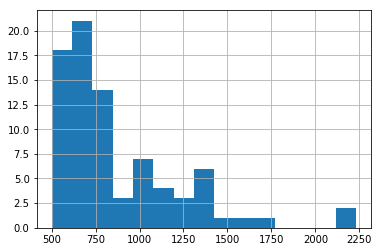

In [1776]:
c.loc[c.ite == 'predict'].iki.hist(bins=15)

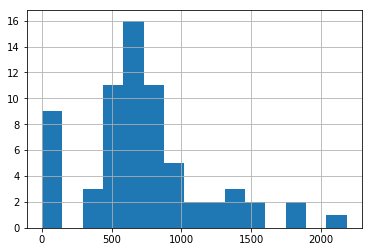

In [1777]:
b.loc[b.ite == 'predict'].iki.hist(bins=15)

In [1781]:
b.loc[(b.ite == 'predict') & (b.iki < 200)]

,ts_id,key,text_field,is_forward,lev_dist,len_diff,iki,ite,is_rep,entry_id,iki_norm
15,1626925.0,Caledonian,Arkansas Caledonian,True,5,5.0,138.0,predict,False,1.0,13.800000
1720,1647690.0,different,Did you different,True,3,3.0,46.0,predict,False,2.0,5.111111
3352,1735933.0,undefined,What number should he call you on,False,2,2.0,4.0,predict,False,-3.0,0.444444
4047,1736144.0,undefined,Let's,False,2,2.0,69.0,predict,False,-3.0,7.666667
4228,1752162.0,ur,"Currently, we are focusing our",True,2,2.0,36.0,predict,False,5.0,18.000000
4242,1752162.0,ites,"Currently, we are focusing our resources in do...",True,4,4.0,23.0,predict,False,17.0,5.750000
4257,1752169.0,Bob,Bob,True,3,3.0,17.0,predict,False,3.0,5.666667
4342,1752184.0,Jan,Jan,True,3,3.0,18.0,predict,False,3.0,6.000000
4384,1752195.0,re,The team Nate says were,True,2,2.0,19.0,predict,False,7.0,9.500000


In [1783]:
c.loc[c.ts_id == 1735933.0]

,ts_id,entry_id,key,text_field,is_forward,lev_dist,len_diff,iki,ite,is_rep,iki_norm
3337,1735933.0,0.0,What,What,True,45,NaN,NaN,swype,True,NaN
3338,1735933.0,-1.0,,What,True,1,1.0,8.0,none,False,8.000000
3339,1735933.0,1.0,number,What number,True,6,6.0,1661.0,swype,True,276.833333
3340,1735933.0,-1.0,,What number,True,1,1.0,4.0,none,False,4.000000
3341,1735933.0,2.0,should,What number should,True,6,6.0,407.0,swype,True,67.833333
3342,1735933.0,-1.0,,What number should,True,1,1.0,3.0,none,False,3.000000
3343,1735933.0,3.0,be,What number should be,True,2,2.0,770.0,swype,True,385.000000
3344,1735933.0,-1.0,,What number should be,True,1,1.0,4.0,none,False,4.000000
3345,1735933.0,4.0,call,What number should be call,True,4,4.0,635.0,swype,True,158.750000
3346,1735933.0,-1.0,,What number should be call,True,1,1.0,5.0,none,False,5.000000


In [1762]:
c.loc[(c.ite == 'predict') & (b.ite != 'predict')].shape

(31, 11)

In [1763]:
c.loc[(c.ite != 'predict') & (b.ite == 'predict')].shape

(17, 11)

#### Autocorr

In [1764]:
# Case 1: The last action of an entry has multiple characters AND there are multiple actions AND fast
index_last = c.groupby(['ts_id','entry_id']).tail(1).index
mask = (c.index.isin(index_last)) & (c.key.str.len() > 1) & (c.entry_id == c.entry_id.shift(1))
mask &= (c.lev_dist > 0) & (c.ite != 'swype') & (c.iki < 300)
c.loc[mask,'ite'] = 'autocorr'

c.loc[c.entry_id < 0,'ite'] = 'none'

In [1773]:
c.loc[c.ts_id == 1715764.0]

,ts_id,entry_id,key,text_field,is_forward,lev_dist,len_diff,iki,ite,is_rep,iki_norm
2543,1715764.0,0.0,Whee,Whee,True,62,NaN,NaN,swype,False,NaN
2544,1715764.0,0.0,When,When,True,1,0.0,222.0,swype,True,55.500000
2545,1715764.0,-1.0,,When,True,1,1.0,250.0,none,False,250.000000
2546,1715764.0,1.0,do,When do,True,2,2.0,108.0,swype,False,54.000000
2547,1715764.0,1.0,do,When do,True,0,0.0,32.0,swype,False,16.000000
2548,1715764.0,-1.0,,When do,True,1,1.0,290.0,none,False,290.000000
2549,1715764.0,2.0,we,When do we,True,2,2.0,72.0,none,True,36.000000
2550,1715764.0,-1.0,,When do we,True,1,1.0,888.0,none,False,888.000000
2551,1715764.0,3.0,ten,When do we ten,True,3,3.0,247.0,swype,False,82.333333
2552,1715764.0,3.0,revote,When do we revote,True,5,3.0,314.0,swype,False,52.333333


In [1770]:
c.loc[(c.ite == 'autocorr') & (b.ite != 'autocorr')]

,ts_id,entry_id,key,text_field,is_forward,lev_dist,len_diff,iki,ite,is_rep,iki_norm
15,1626925.0,1.0,Caledonian,Arkansas Caledonian,True,5,5.0,138.0,autocorr,False,13.800000
541,1626969.0,0.0,Toome,Toome,True,1,-1.0,173.0,autocorr,False,34.600000
1720,1647690.0,2.0,different,Did you different,True,3,3.0,46.0,autocorr,False,5.111111
2282,1715746.0,3.0,Fitripaldi,Emerson Fitripaldi,True,1,1.0,276.0,autocorr,False,27.600000
2433,1715755.0,9.0,ut,"About 20 were Americans, but",True,1,1.0,182.0,autocorr,False,91.000000
2483,1715761.0,8.0,ill,I will,True,1,1.0,134.0,autocorr,False,44.666667
2505,1715761.0,17.0,PM,I will not make the meeting at 1 PM,True,1,1.0,229.0,autocorr,False,114.500000
2561,1715764.0,6.0,El,When do we review with El,True,1,1.0,285.0,autocorr,False,142.500000
2566,1715764.0,7.0,Paso,When do we review with El Paso,True,1,1.0,296.0,autocorr,False,74.000000
3603,1736106.0,7.0,ce,I have a high level in my office,True,2,2.0,11.0,autocorr,False,5.500000


In [1768]:
c.loc[(c.ite != 'autocorr') & (b.ite == 'autocorr')].shape

(19, 11)

In [1765]:
c.groupby('ite').iki.describe()

,count,mean,std,min,25%,50%,75%,max
ite,,,,,,,,
autocorr,45.0,108.711111,94.046802,3.0,11.00,82.0,181.0,296.0
none,4832.0,321.514901,367.677047,2.0,132.00,210.0,382.0,4343.0
predict,81.0,871.185185,358.872579,501.0,632.00,736.0,1007.0,2232.0
swype,492.0,738.863821,779.860894,4.0,229.75,361.5,993.0,5858.0


In [1766]:
c.groupby('ite').iki_norm.describe()

,count,mean,std,min,25%,50%,75%,max
ite,,,,,,,,
autocorr,45.0,30.041023,34.884671,0.800000,5.000000,13.800000,40.142857,142.5
none,4832.0,295.173514,355.987347,0.444444,83.000000,195.000000,365.000000,4343.0
predict,81.0,169.400374,100.437001,59.700000,107.428571,137.000000,190.857143,558.0
swype,492.0,176.700734,193.320953,0.571429,45.800000,87.208333,251.392857,1734.0


In [1730]:
c.loc[c.ts_id == c.loc[c.text_field.str.contains('forward',regex=False),'ts_id'].iloc[0]]

,ts_id,entry_id,key,text_field,is_forward,lev_dist,len_diff,iki,ite,is_rep,iki_norm
2043,1715726.0,0.0,The,The,True,37,NaN,NaN,swype,True,NaN
2044,1715726.0,-1.0,,The,True,1,1.0,303.0,none,False,303.000000
2045,1715726.0,1.0,Show,The Show,True,4,4.0,1004.0,swype,False,251.000000
2046,1715726.0,1.0,Spiritually,The Spiritually,True,10,7.0,290.0,swype,False,26.363636
2047,1715726.0,1.0,Spanish,The Spanish,True,8,-4.0,249.0,swype,True,35.571429
2048,1715726.0,-1.0,,The Spanish,True,1,1.0,684.0,none,False,684.000000
2049,1715726.0,2.0,feed,The Spanish feed,True,4,4.0,628.0,swype,False,157.000000
2050,1715726.0,2.0,feeder,The Spanish feeder,True,2,2.0,338.0,swype,False,56.333333
2051,1715726.0,2.0,feeders,The Spanish feeders,True,1,1.0,350.0,swype,False,50.000000
2052,1715726.0,2.0,Federation,The Spanish Federation,True,6,3.0,320.0,swype,True,32.000000


In [1461]:
lab_log.loc[lab_log.ts_id == 1752176.0]

,log_data_id,ts_id,type,key,text_field,timestamp,input_len,lev_dist,input_len_prev,lev_dist_prev,swype,predict,autocorr,iki,iki_norm,len_diff,ite,participant_id
4817,231275794,1752176.0,input,Tuu,Tuu,1.547625e+12,3.0,31.0,33.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,swype,267956
4818,231275797,1752176.0,input,oot,Tuu oot,1.547625e+12,7.0,4.0,3.0,31.0,1.0,0.0,0.0,408.0,102.000000,4.0,swype,267956
4819,231275800,1752176.0,input,ab,Tuu oot ab,1.547625e+12,10.0,3.0,7.0,4.0,1.0,0.0,0.0,1285.0,428.333333,3.0,swype,267956
4820,231275803,1752176.0,input,and,Tuu oot ab and,1.547625e+12,14.0,4.0,10.0,3.0,1.0,0.0,0.0,801.0,200.250000,4.0,swype,267956
4821,231275806,1752176.0,input,NaN,Tuu oot ab an,1.547625e+12,13.0,1.0,14.0,4.0,0.0,0.0,0.0,230.0,230.000000,-1.0,none,267956
4822,231275807,1752176.0,input,NaN,Tuu oot ab a,1.547625e+12,12.0,1.0,13.0,1.0,0.0,0.0,0.0,6.0,6.000000,-1.0,none,267956
4823,231275808,1752176.0,input,NaN,Tuu oot ab,1.547625e+12,11.0,1.0,12.0,1.0,0.0,0.0,0.0,6.0,6.000000,-1.0,none,267956
4824,231275811,1752176.0,input,NaN,Tuu oot ab,1.547625e+12,10.0,1.0,11.0,1.0,0.0,0.0,0.0,282.0,282.000000,-1.0,none,267956
4825,231275814,1752176.0,input,NaN,Tuu oot a,1.547625e+12,9.0,1.0,10.0,1.0,0.0,0.0,0.0,104.0,104.000000,-1.0,none,267956
4826,231275817,1752176.0,input,NaN,Tuu oot,1.547625e+12,8.0,1.0,9.0,1.0,0.0,0.0,0.0,117.0,117.000000,-1.0,none,267956


### Legacy

In [1422]:
b['space_added'] = 'none'

# Case 1: merge quick spaces with the previous entry
mask = (b.key.shift(-1) == ' ') & (b.iki.shift(-1) < 30)
b.loc[mask,['key','lev_dist','len_diff','iki']] += b.shift(-1).loc[mask,['key','lev_dist','len_diff','iki']]
b.loc[mask,'space_added'] = 'trailing'
b.drop(b.loc[mask].index + 1, inplace=True)
b.reset_index(drop=True,inplace=True)

# Case 2: merge slow spaces with the following entry (if the following is more than one char, which suggests swype)
mask = (b.key.shift(1) == ' ') & (b.iki.shift(1) > 30) & (b.key.str.len() > 1)
b.loc[mask,['key','lev_dist','len_diff','iki']] += b.shift(1).loc[mask,['key','lev_dist','len_diff','iki']]
b.loc[mask,'space_added'] = 'leading'
b.drop(b.loc[mask].index - 1, inplace=True)
b.reset_index(drop=True,inplace=True)

# Case 3: already leading space with multiple characters following the space
mask = (b.key.str[0] == ' ') & (b.space_added == 'none') & (b.key.str.len() > 2)
b.loc[mask,'space_added'] = 'leading'

# Case 4: already leading space but only one character following the space
# Do nothing. This is not actually a leading space
pass

In [1427]:
b['space_added'] = 'none'

# Case 3: Split leading space from characters
mask = (b.key.str[0] == ' ') & (b.key.str.len() > 1)
# Create single space entries
df_space = b.loc[mask].copy()
df_space.key = ' '
df_space.index -= 0.5
df_space.iki = 0
df_space.lev_dist = 1
df_space.len_diff = 1
df_space.is_forward = True
df_space.ite = 'none'
# Remove the space
b.loc[mask,'key'] = b.loc[mask].key.str.strip(' ')
b.loc[mask,'lev_dist'] -= 1
b.loc[mask,'len_diff'] -= 1
b.loc[mask,'space_added'] = 'leading'
# Combine the space
b = pd.concat([b,df_space],sort=False)
b = b.sort_index().reset_index()

pass

In [1468]:
first_instance = b.loc[~b.is_forward].groupby(['ts_id','entry_id']).head(1)
total_time = b.loc[~b.is_forward].groupby(['ts_id','entry_id']).iki.sum()

b.loc[first_instance.index,'key'] = '_'
b.loc[first_instance.index,'iki'] = total_time.values

# Remove the rest
mask = (~b.index.isin(first_instance.index)) & (~b.is_forward)
b.drop(b.loc[mask].index,inplace=True)

In [1469]:
# Now that we condensed the non-forward entries, reassign the entry ids
b['contains_sep'] = b.key.str.contains(' |_') # Dummy
b['entry_id'] = b.groupby('ts_id').contains_sep.cumsum()
b.drop('contains_sep',axis=1,inplace=True) # Remove dummy

In [1262]:
# Case 1: Has leading spaces
c.loc[c.space_added == 'leading','ite'] = 'swype'

# Case 2: The first action of the first entry has multiple characters (not including spaces)
index_first = c.loc[c.entry_id == 0].groupby(['ts_id']).head(1).index
mask = (c.index.isin(index_first)) & (c.key.str.strip(' ').str.len() > 1)
c.loc[mask,'ite'] = 'swype'

# Case 2: The first action of an entry has multiple characters (not including spaces)
index_first = c.groupby(['ts_id','entry_id']).head(1).index
mask = (c.index.isin(index_first)) & (c.key.str.strip(' ').str.len() > 1) & (c.iki_norm > 130)
c.loc[mask,'ite'] = 'swype'

# Case 3: Fill in the same entry as a swype
c.set_index(['ts_id','entry_id'],inplace=True)
c.loc[c.loc[c.ite == 'swype'].index,'ite'] = 'swype'
c.reset_index(inplace=True)

# TODO Case 2 could also mean a prediction
# TODO what about swype followed by a prediction correction?
# TODO what about backspace followed by a prediction?

